In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop,SGD,Adam
from keras import datasets, layers, models

import tensorflow as tf

import cv2
import os
import pdb

import numpy as np
import random

In [2]:
labels = ['yes', 'no']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        print(path)
        
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
                random.shuffle(data)
            except Exception as e:
                print(e)
    
    return np.asanyarray(data)

all_data = get_data('brain_tumor_dataset/')


brain_tumor_dataset/yes
brain_tumor_dataset/no


/var/folders/d0/358bfgsx4js7vlrx9xsm_5fr0000gn/T/ipykernel_72323/1229627865.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asanyarray(data)


In [3]:
x_data = []
y_data = []
 # Iterate over the Data
for x in all_data:
    x_data.append(x[0])        # Get the X_Data
    y_data.append(x[1])        # get the label

    X_Data = np.asarray(x_data)      
    Y_Data = np.asarray(y_data)

    # reshape x_Data and y_Data
    X_Data = X_Data.reshape(-1, img_size, img_size,3)
    Y_Data = Y_Data.reshape(-1, 1)

In [4]:
import pdb
def standardize(image_data):
        image_data = image_data.astype(float)
        mean = np.mean(image_data, axis=0)
        image_data -= mean
        std = np.std(image_data, axis=0)
        image_data /= std
        return image_data, mean, std

X_Data, mean, std =   standardize(X_Data)


X_Data = tf.image.rgb_to_grayscale(X_Data)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-10-17 08:53:16.170835: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-17 08:53:16.171390: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
print(X_Data.shape)
print(Y_Data.shape)

(253, 224, 224, 1)
(253, 1)


In [6]:

num_test_images = round(X_Data.shape[0] * 0.2)
num_train_images =  X_Data.shape[0] - num_test_images

x_train = X_Data[:num_train_images] #find better way do divide data
y_train = Y_Data[:num_train_images] #find better way do divide data
x_test = X_Data[num_train_images:] #find better way do divide data
y_test = Y_Data[num_train_images:] #find better way do divide data

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



(202, 224, 224, 1)
(202, 1)
(51, 224, 224, 1)
(51, 1)


/Users/simaosa/Library/Python/3.9/lib/python/site-packages/matplotlib/text.py:1242: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


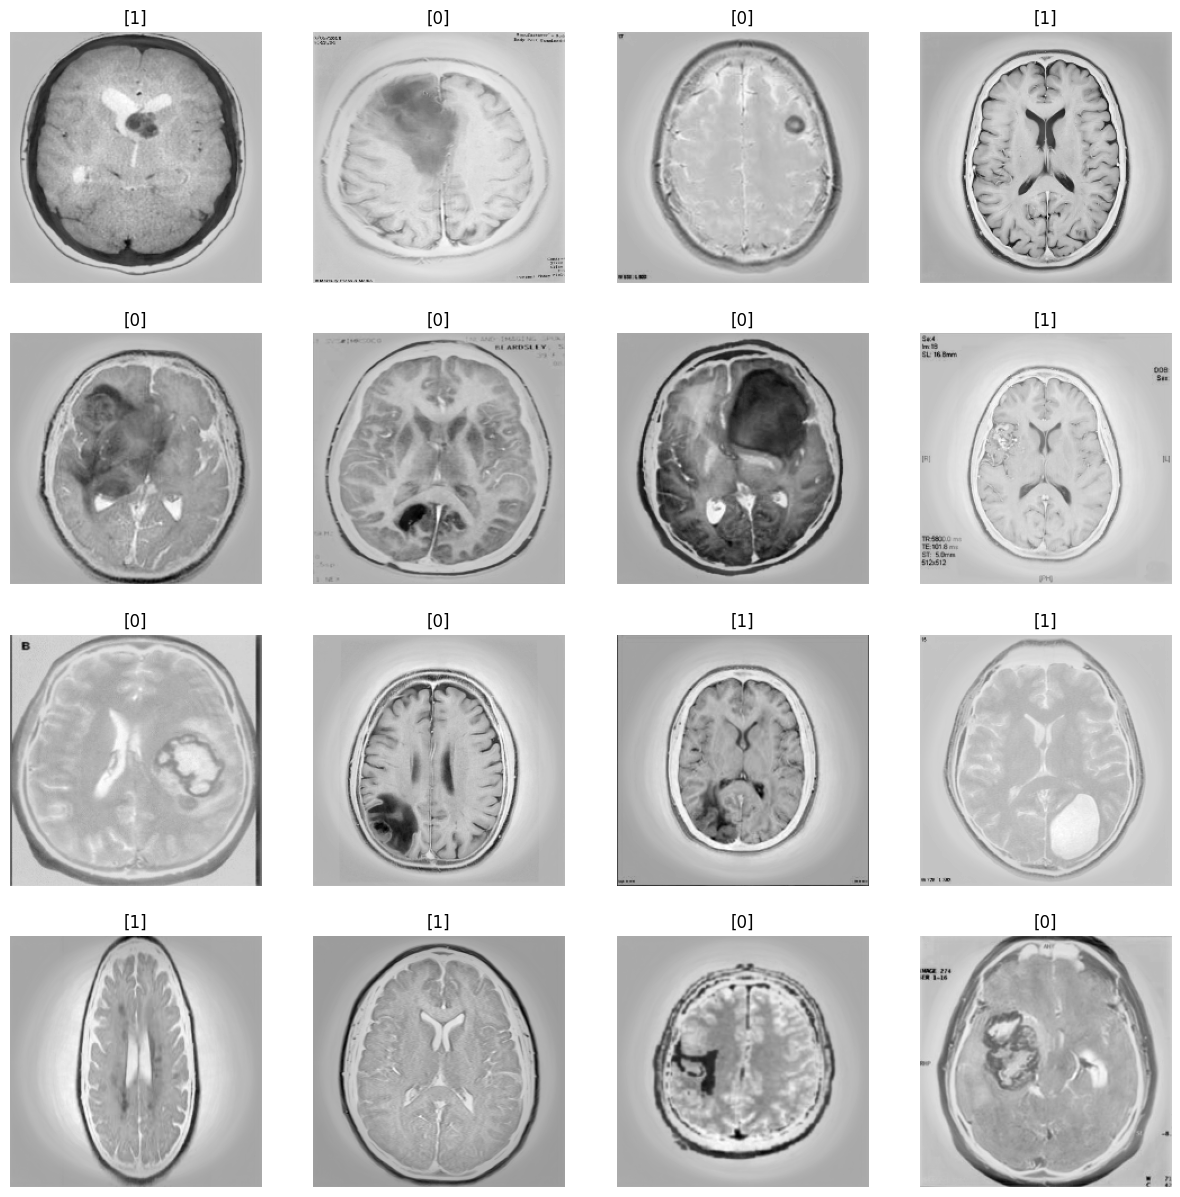

In [7]:
def plot_multi(i):
    '''Plots 16 digits, starting with digit i'''
    nplots = 16
    fig = plt.figure(figsize=(15,15))
    for j in range(nplots):
        plt.subplot(4,4,j+1)
        plt.imshow(X_Data[i+j], cmap='binary')
        plt.title(Y_Data[i+j])
        plt.axis('off')
    plt.show()

plot_multi(14)

In [8]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), padding = 'SAME', activation='relu', input_shape=(224, 224, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), padding = 'SAME', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), padding = 'SAME', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(10, activation='softmax'))

# as metric we choose the accuracy: the total number of correct predictions made
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [9]:
validation_data_ = (x_test, y_test)
                
history = model.fit(x_train, y_train, epochs=10, batch_size=256, 
                    validation_data=validation_data_) ##can the batch size be bigger than the number of images in the data?

Epoch 1/10


2022-10-17 08:53:30.421559: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-17 08:53:30.699105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
predictions = model.predict(x_test)
predictions_index = np.argmax(predictions, axis=1) # Convert one-hot to index; remember indexing starts from 0; index takes integers values in [0,9]
predictions_index
classname = ['Tumor','Healthy']

In [ ]:

# Plot a random sample of 15 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 20))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    predict_index = np.argmax(predictions[index])
    true_index = y_test[index][0]
    # Set the title for each image
    ax.set_title("P: {} (R: {})".format(classname[predict_index], 
                                  classname[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
    # Display each image
    ax.imshow(np.squeeze(x_test[index]), cmap = 'jet')
plt.show()